In [14]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [15]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [16]:
# Load and Preprocess Data
# Load the data
df = pd.read_csv('cbdc_transactions.csv')

# Preprocess the data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['transaction_type'])

# Select features for the model
features = ['amount', 'hour', 'day_of_week', 'transaction_type_exchange', 'transaction_type_payment', 'transaction_type_transfer']

X = df[features]
y = df['is_anomaly']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Model
# Train the Isolation Forest model
clf = IsolationForest(contamination=float(0.01), random_state=42)
clf.fit(X_train_scaled)

# Predict anomalies
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

# Convert predictions to binary (0 for inlier, 1 for outlier)
y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

In [18]:
# Model Evaluation
# Calculate additional metrics
f1 = f1_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, -clf.score_samples(X_test_scaled))
roc_auc = auc(fpr, tpr)

# Calculate log loss
# Note: Isolation Forest doesn't provide probability estimates, so we'll use the anomaly scores
anomaly_scores = -clf.score_samples(X_test_scaled)
# Normalize scores to [0, 1] range for log loss calculation
anomaly_scores_normalized = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
logloss = log_loss(y_test, anomaly_scores_normalized)

In [20]:
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Area under ROC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Accuracy: 0.9832
Area under ROC: 0.8959
Log Loss: 0.2680

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1998
        True       0.17      0.14      0.15        22

    accuracy                           0.98      2020
   macro avg       0.58      0.56      0.57      2020
weighted avg       0.98      0.98      0.98      2020



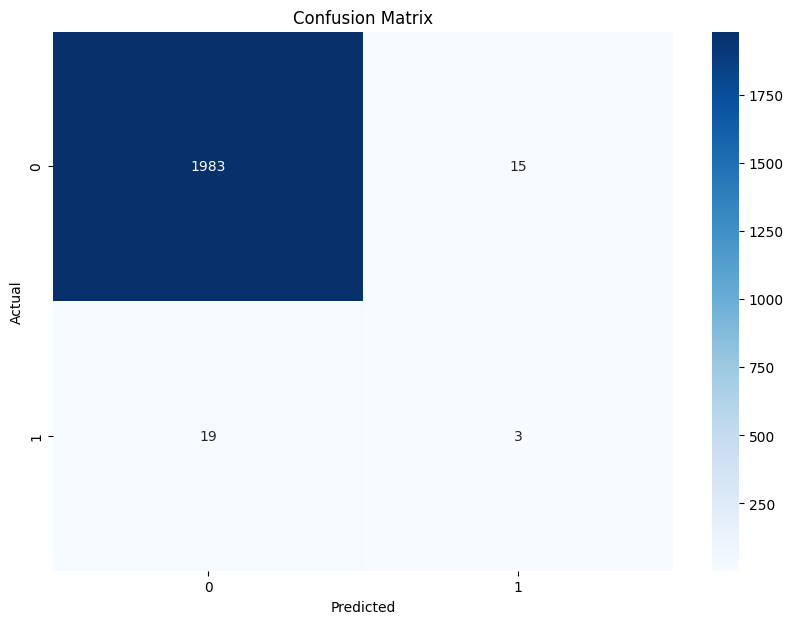

In [21]:
# Visualizations
# Visualization 1: Confusion Matrix
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

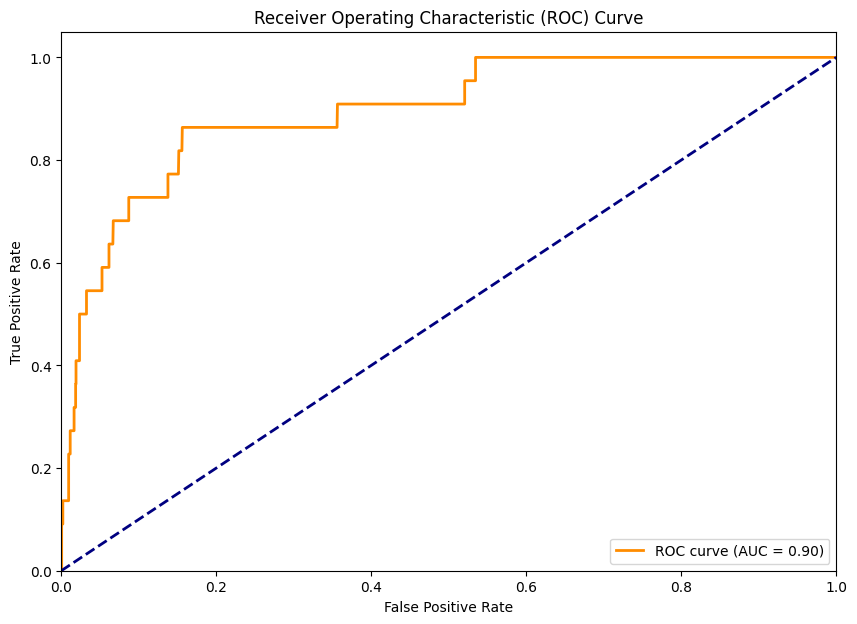

In [22]:
# Visualization 2: ROC Curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

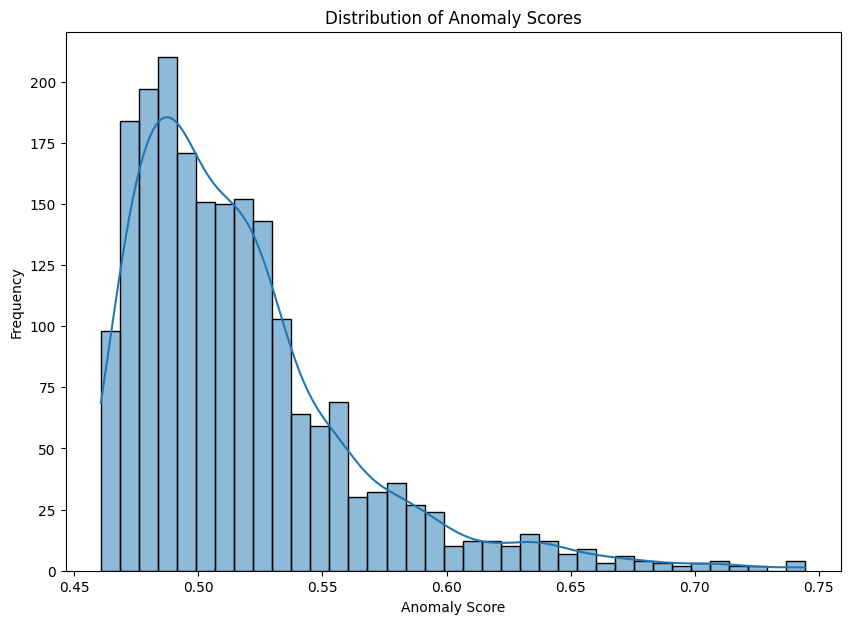

In [24]:
# Visualization 3: Distribution of Anomaly Scores
plt.figure(figsize=(10,7))
sns.histplot(anomaly_scores, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Save the model
joblib.dump(clf, 'isolation_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
